In [3]:
import pandas as pd

# Preprocessing function for a single chunk
def process_chunk(chunk):
    # Ensure timestamps
    chunk['event_time'] = pd.to_datetime(chunk['event_time'])
    
    # Sort for time-based calculations
    chunk = chunk.sort_values(by=['user_session', 'event_time'])

    # Session-level features
    session_group = chunk.groupby('user_session')

    session_features = session_group.agg({
        'user_id': 'first',
        'event_time': ['min', 'max'],  # Changed from min, max to 'min', 'max'
        'event_type': lambda x: x.value_counts().to_dict(),
        'brand': pd.Series.nunique,
        'category_code': pd.Series.nunique,
        'price': 'sum'
    })

    # Flatten column names
    session_features.columns = ['user_id', 'session_start', 'session_end',
                                'event_type_counts', 'unique_brands',
                                'unique_categories', 'total_spent']

    # Additional features
    session_features['session_duration_min'] = (
        session_features['session_end'] - session_features['session_start']
    ).dt.total_seconds() / 60

    # Extract event counts from event_type_counts
    session_features['num_views'] = session_features['event_type_counts'].apply(lambda d: d.get('view', 0))
    session_features['num_cart'] = session_features['event_type_counts'].apply(lambda d: d.get('cart', 0))
    session_features['num_purchase'] = session_features['event_type_counts'].apply(lambda d: d.get('purchase', 0))
    session_features['converted'] = session_features['num_purchase'] > 0

    return session_features.reset_index()


In [4]:
all_sessions = []

use_cols = ['user_id', 'event_time', 'event_type', 'user_session', 'brand', 'category_code', 'price']
csv_path = r'C:\Users\prana\Documents\fraud_detection\data\2019-Oct.csv'

# Read and process in chunks
for i, chunk in enumerate(pd.read_csv(csv_path, chunksize=1_000_000, usecols=use_cols)):
    print(f"Processing chunk {i+1}")
    processed = process_chunk(chunk)
    all_sessions.append(processed)

# Combine all processed chunks
final_df = pd.concat(all_sessions, ignore_index=True)


Processing chunk 1
Processing chunk 2
Processing chunk 3
Processing chunk 4
Processing chunk 5
Processing chunk 6
Processing chunk 7
Processing chunk 8
Processing chunk 9
Processing chunk 10
Processing chunk 11
Processing chunk 12
Processing chunk 13
Processing chunk 14
Processing chunk 15
Processing chunk 16
Processing chunk 17
Processing chunk 18
Processing chunk 19
Processing chunk 20
Processing chunk 21
Processing chunk 22
Processing chunk 23
Processing chunk 24
Processing chunk 25
Processing chunk 26
Processing chunk 27
Processing chunk 28
Processing chunk 29
Processing chunk 30
Processing chunk 31
Processing chunk 32
Processing chunk 33
Processing chunk 34
Processing chunk 35
Processing chunk 36
Processing chunk 37
Processing chunk 38
Processing chunk 39
Processing chunk 40
Processing chunk 41
Processing chunk 42
Processing chunk 43


In [5]:
# Basic information
final_df.info()

# Preview the first few rows
final_df.head()

# Check for missing values
final_df.isnull().sum()

# Summary statistics for numerical columns
final_df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9339973 entries, 0 to 9339972
Data columns (total 13 columns):
 #   Column                Dtype              
---  ------                -----              
 0   user_session          object             
 1   user_id               int64              
 2   session_start         datetime64[ns, UTC]
 3   session_end           datetime64[ns, UTC]
 4   event_type_counts     object             
 5   unique_brands         int64              
 6   unique_categories     int64              
 7   total_spent           float64            
 8   session_duration_min  float64            
 9   num_views             int64              
 10  num_cart              int64              
 11  num_purchase          int64              
 12  converted             bool               
dtypes: bool(1), datetime64[ns, UTC](2), float64(2), int64(6), object(2)
memory usage: 864.0+ MB


,user_id,unique_brands,unique_categories,total_spent,session_duration_min,num_views,num_cart,num_purchase
count,9.339973e+06,9.339973e+06,9.339973e+06,9.339973e+06,9.339973e+06,9.339973e+06,9.339973e+06,9.339973e+06
mean,5.352677e+08,1.616866e+00,8.571003e-01,1.319477e+03,5.340178e+00,4.366115e+00,9.919879e-02,7.953438e-02
std,1.907394e+07,1.665329e+00,7.180667e-01,2.632350e+03,2.380223e+01,6.548091e+00,5.713396e-01,3.334387e-01
min,3.386938e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.165224e+08,1.000000e+00,0.000000e+00,1.701400e+02,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.340627e+08,1.000000e+00,1.000000e+00,4.850400e+02,1.016667e+00,2.000000e+00,0.000000e+00,0.000000e+00
75%,5.542105e+08,2.000000e+00,1.000000e+00,1.380330e+03,4.383333e+00,5.000000e+00,0.000000e+00,0.000000e+00
max,5.662809e+08,1.180000e+02,5.200000e+01,4.115232e+05,1.294550e+03,1.137000e+03,1.180000e+02,4.800000e+01


In [6]:
final_df.isnull().sum()

user_session            0
user_id                 0
session_start           0
session_end             0
event_type_counts       0
unique_brands           0
unique_categories       0
total_spent             0
session_duration_min    0
num_views               0
num_cart                0
num_purchase            0
converted               0
dtype: int64

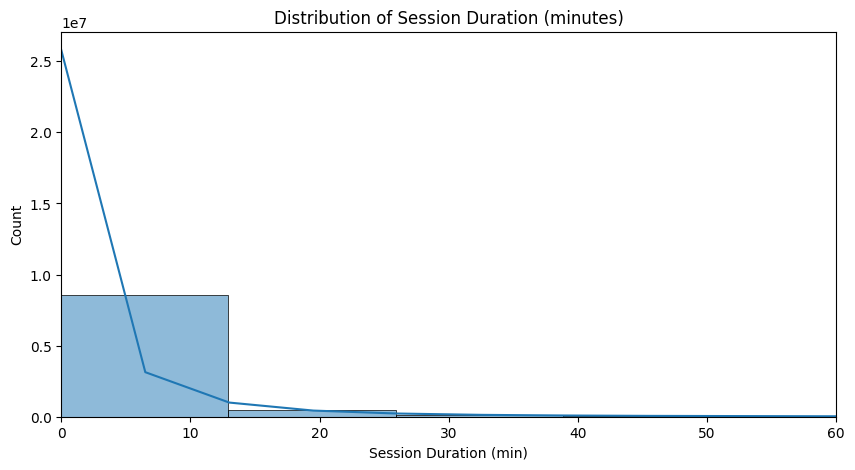

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(final_df['session_duration_min'], bins=100, kde=True)
plt.xlim(0, 60)  # Focus on the first hour
plt.title('Distribution of Session Duration (minutes)')
plt.xlabel('Session Duration (min)')
plt.show()


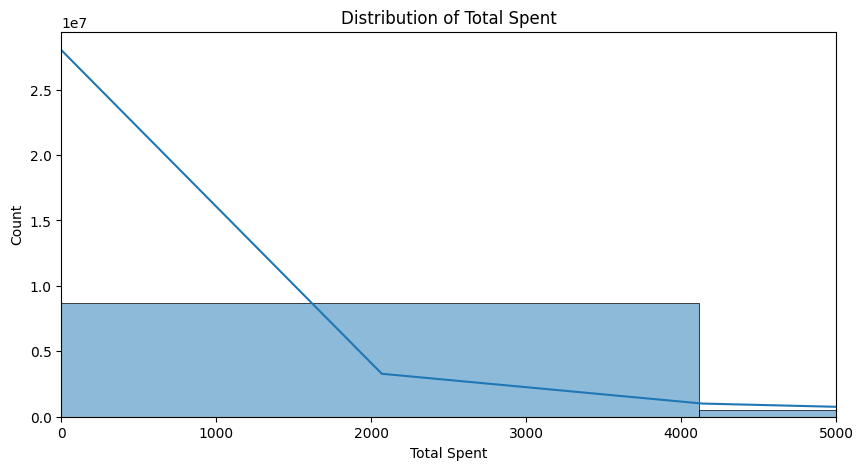

In [8]:
plt.figure(figsize=(10, 5))
sns.histplot(final_df['total_spent'], bins=100, kde=True)
plt.xlim(0, 5000)  # Zoom in to remove extreme outliers
plt.title('Distribution of Total Spent')
plt.xlabel('Total Spent')
plt.show()


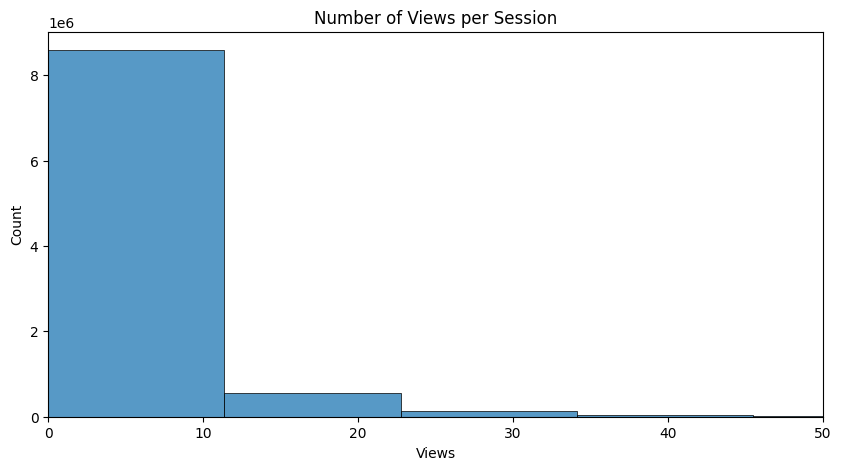

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(final_df['num_views'], bins=100)
plt.xlim(0, 50)
plt.title('Number of Views per Session')
plt.xlabel('Views')
plt.show()


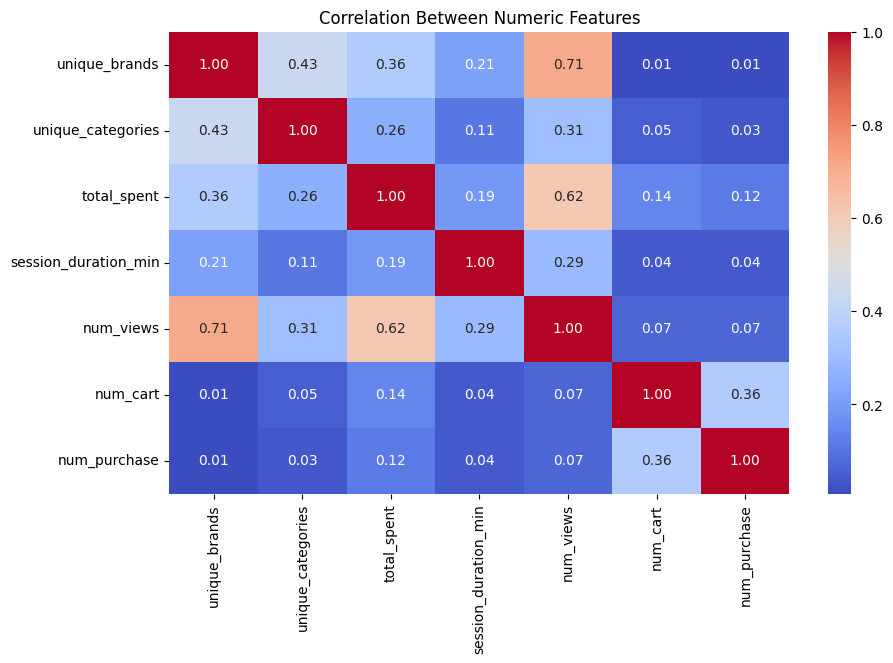

In [10]:
numeric_cols = ['unique_brands', 'unique_categories', 'total_spent', 'session_duration_min',
                'num_views', 'num_cart', 'num_purchase']

plt.figure(figsize=(10, 6))
corr = final_df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Numeric Features")
plt.show()

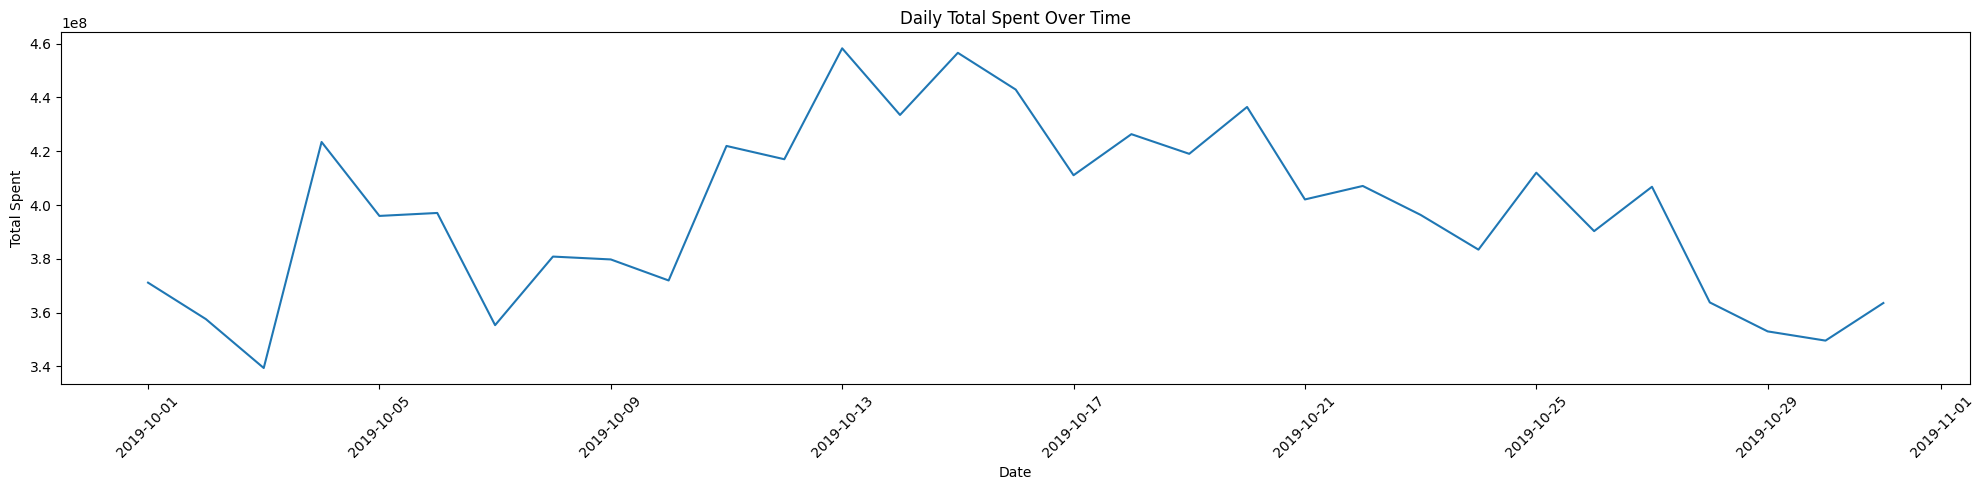

In [12]:
# Ensure datetime format
final_df['session_start'] = pd.to_datetime(final_df['session_start'])

# Group by day and aggregate
daily_spent = final_df.groupby(final_df['session_start'].dt.date)['total_spent'].sum()

plt.figure(figsize=(20, 5))
daily_spent.plot()
plt.title('Daily Total Spent Over Time')
plt.xlabel('Date')
plt.ylabel('Total Spent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


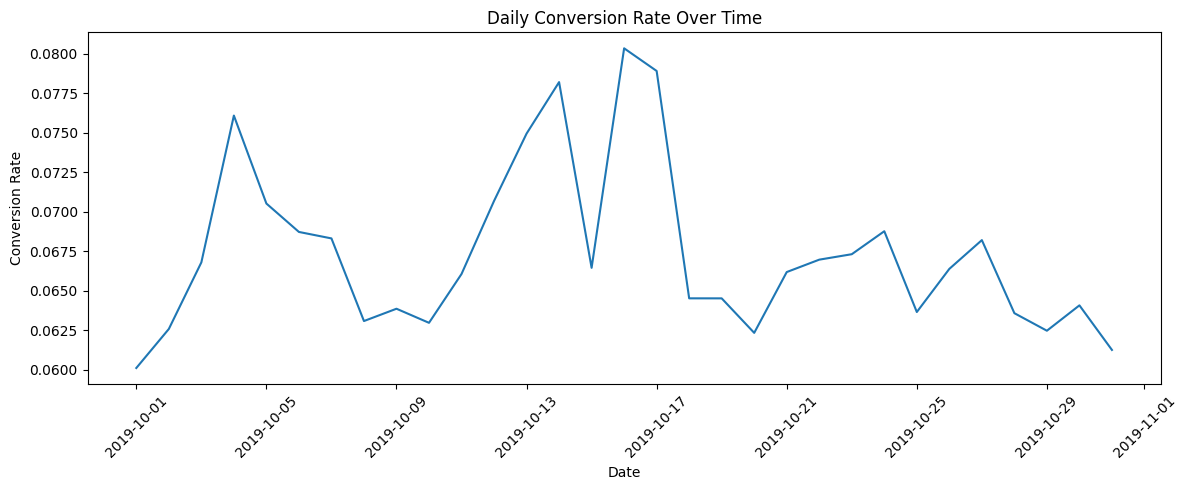

In [13]:
daily_conversion = final_df.groupby(final_df['session_start'].dt.date)['converted'].mean()

plt.figure(figsize=(12, 5))
daily_conversion.plot()
plt.title('Daily Conversion Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [19]:
#day with the highest coversion in oct 2019
daily_conversion = final_df.groupby(final_df['session_start'].dt.date)['converted'].mean()
daily_conversion[daily_conversion>0.08]

session_start
2019-10-16    0.080345
Name: converted, dtype: float64

In [20]:
# Copy to avoid altering the original data
df = final_df.copy()

# List of columns to normalize
features_to_normalize = [
    'session_duration_min', 'num_views', 'num_cart', 'num_purchase',
    'unique_brands', 'unique_categories', 'total_spent'
]

# Normalize using Min-Max scaling (scaled 0 to 1)
for col in features_to_normalize:
    df[f'{col}_norm'] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())


In [22]:
df['fraud_score'] = (
    0.25 * df['session_duration_min_norm'] +
    0.20 * df['num_views_norm'] +
    0.15 * df['num_cart_norm'] +
    0.15 * df['unique_brands_norm'] +
    0.10 * df['unique_categories_norm'] +
    0.10 * df['total_spent_norm'] -    # high spend can be suspicious
    0.15 * df['num_purchase_norm']     # purchases reduce likelihood of fraud
)


In [23]:
df_sorted = df.sort_values(by='fraud_score', ascending=False)
df_sorted[['user_id', 'fraud_score']].head(10)


,user_id,fraud_score
6535046,542048657,0.461146
1716098,513605798,0.382981
8096152,555597248,0.364551
3295676,559520192,0.362797
444881,513605798,0.353901
660554,513605798,0.304706
3316390,524261028,0.290746
9332180,566165785,0.288969
7049211,513851612,0.276874
532188,513762891,0.276156


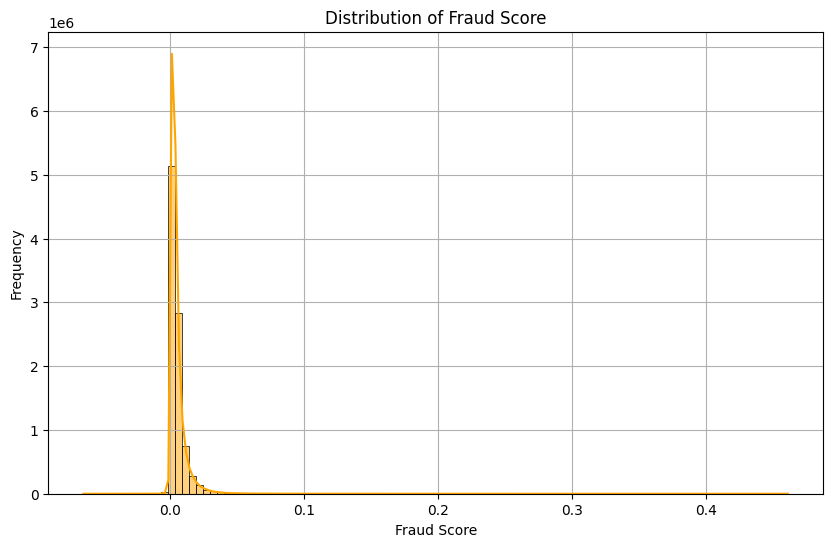

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(df['fraud_score'], bins=100, kde=True, color='orange')
plt.title('Distribution of Fraud Score')
plt.xlabel('Fraud Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [31]:
(df['fraud_score']<0).sum()

np.int64(82986)

In [33]:
negative_scores = df[df['fraud_score'] < 0]
print(negative_scores['num_purchase'].describe())


count    82986.000000
mean         1.403454
std          1.019689
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         48.000000
Name: num_purchase, dtype: float64


# Top 10 Suspicious Sessions

In [34]:
top_suspects = df.sort_values('fraud_score', ascending=False).head(10)
top_suspects[['user_id', 'fraud_score', 'session_duration_min', 'num_views', 'num_cart', 'num_purchase', 'total_spent']]


,user_id,fraud_score,session_duration_min,num_views,num_cart,num_purchase,total_spent
6535046,542048657,0.461146,366.250000,1137,0,0,411523.24
1716098,513605798,0.382981,1135.616667,336,0,0,26725.13
8096152,555597248,0.364551,165.866667,349,1,0,186344.93
3295676,559520192,0.362797,171.883333,365,0,0,150424.58
444881,513605798,0.353901,1132.050000,320,0,0,26631.36
660554,513605798,0.304706,1278.883333,105,0,0,7185.23
3316390,524261028,0.290746,177.616667,289,0,0,80762.65
9332180,566165785,0.288969,277.616667,425,0,0,124095.21
7049211,513851612,0.276874,437.666667,555,0,0,326915.76
532188,513762891,0.276156,1293.233333,20,0,0,18152.31


In [35]:
# Label top 1% as fraudulent (adjust threshold as needed)
threshold = df['fraud_score'].quantile(0.99)
df['is_fraud'] = (df['fraud_score'] >= threshold).astype(int)

# Check distribution
df['is_fraud'].value_counts()


is_fraud
0    9246573
1      93400
Name: count, dtype: int64

## fraud trends over time and identifying key behavioral patterns.

In [36]:
df['session_start'] = pd.to_datetime(df['session_start'])

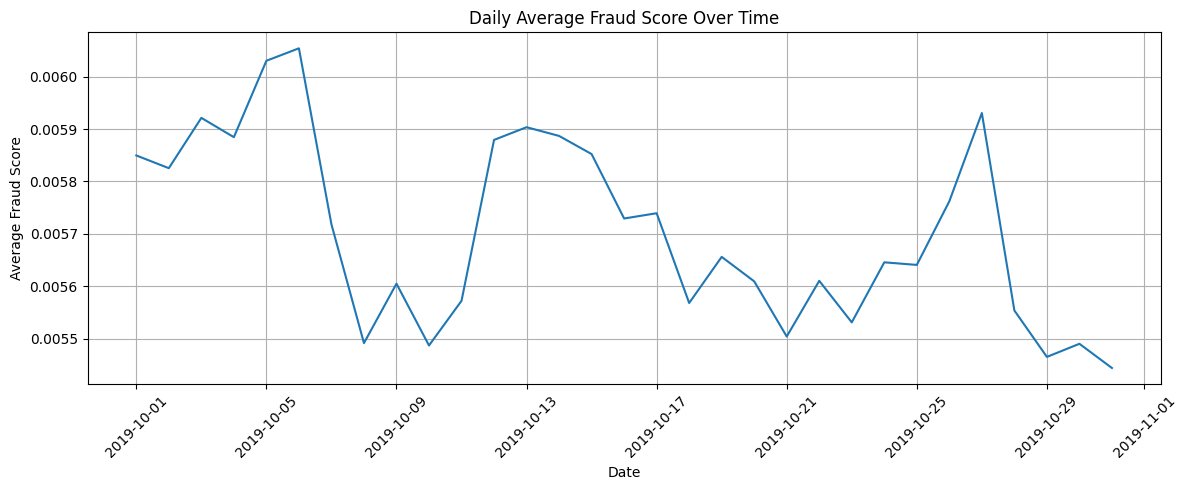

In [37]:
daily_fraud = df.groupby(df['session_start'].dt.date)['fraud_score'].mean()

plt.figure(figsize=(12, 5))
daily_fraud.plot()
plt.title('Daily Average Fraud Score Over Time')
plt.xlabel('Date')
plt.ylabel('Average Fraud Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [43]:
fraud_threshold = df['fraud_score'].quantile(0.95)  # Top 5%
df['fraud_label'] = df['fraud_score'].apply(lambda x: 'High Fraud' if x >= fraud_threshold else 'Normal')


In [45]:
behavioral_features = ['session_duration_min', 'num_views', 'num_cart', 'num_purchase', 'total_spent']
grouped_behavior = df.groupby('fraud_label')[behavioral_features].mean()
print(grouped_behavior.T)


fraud_label            High Fraud       Normal
session_duration_min    50.570536     2.959631
num_views               22.113056     3.432065
num_cart                 0.322071     0.087469
num_purchase             0.078998     0.079563
total_spent           6014.168391  1072.387854


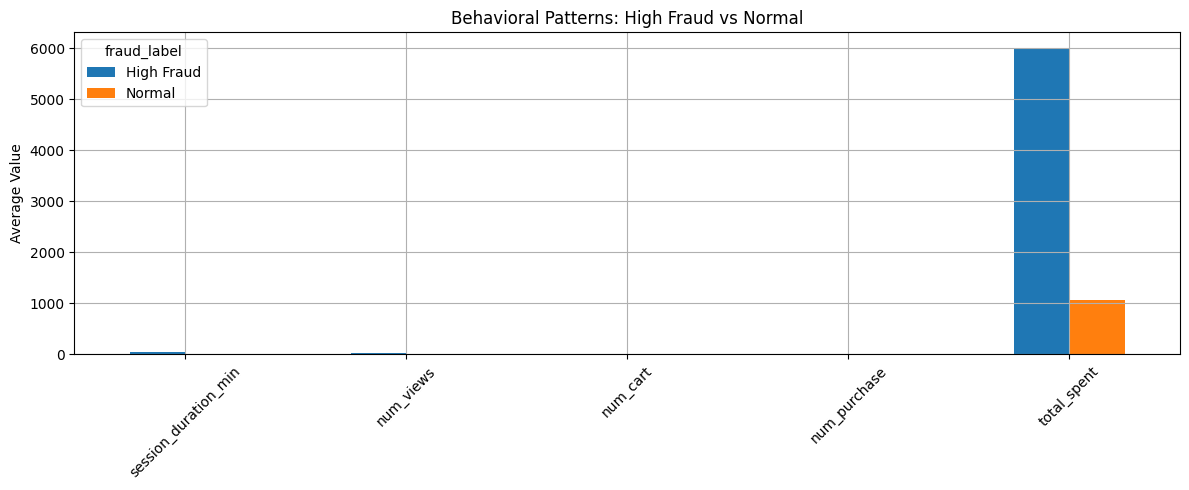

In [48]:
grouped_behavior.T.plot(kind='bar', figsize=(12, 5))
plt.title("Behavioral Patterns: High Fraud vs Normal")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


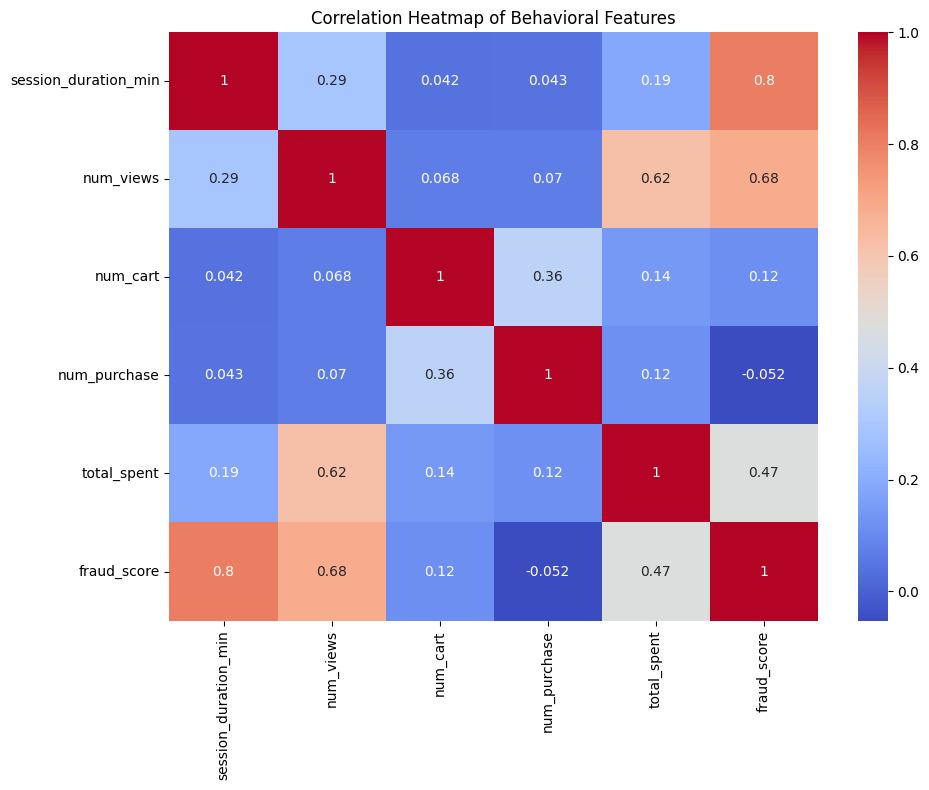

In [50]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(df[[
    'session_duration_min', 'num_views', 'num_cart', 'num_purchase', 
    'total_spent', 'fraud_score'
]].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Behavioral Features")
plt.tight_layout()
plt.show()


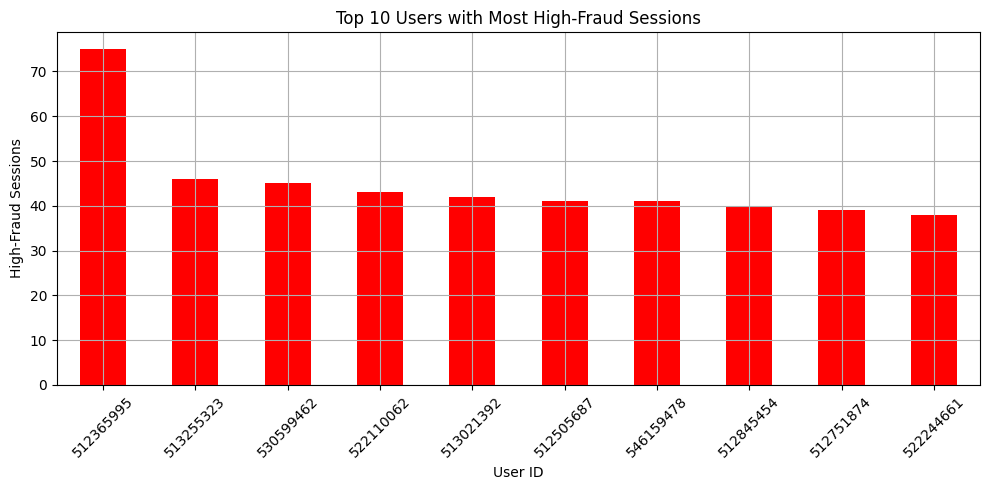

In [51]:
# Top users with most high-fraud sessions
high_fraud_users = df[df['fraud_label'] == 'High Fraud']

repeat_offenders = high_fraud_users['user_id'].value_counts().head(10)

repeat_offenders.plot(kind='bar', figsize=(10, 5), color='red')
plt.title("Top 10 Users with Most High-Fraud Sessions")
plt.xlabel("User ID")
plt.ylabel("High-Fraud Sessions")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [52]:
from scipy.stats import zscore

# Select key numeric features
key_features = ['session_duration_min', 'num_views', 'num_cart', 'total_spent']

# Calculate z-scores
z_scores = final_df[key_features].apply(zscore)

# Flag anomalies where any z-score > 3 or < -3
anomalies_z = (z_scores.abs() > 3).any(axis=1)
final_df['anomaly_zscore'] = anomalies_z

# View how many
print("Anomalies detected using Z-Score:", anomalies_z.sum())


Anomalies detected using Z-Score: 485574


In [53]:
from sklearn.ensemble import IsolationForest

# Prepare input
X = final_df[key_features]
X = X.fillna(0)  # handle missing if any

# Fit model
iso_forest = IsolationForest(contamination=0.01, random_state=42)
final_df['anomaly_iforest'] = iso_forest.fit_predict(X)

# Convert prediction: -1 → anomaly, 1 → normal
final_df['anomaly_iforest'] = final_df['anomaly_iforest'].map({-1: 'Anomaly', 1: 'Normal'})

# Count results
print(final_df['anomaly_iforest'].value_counts())


anomaly_iforest
Normal     9246573
Anomaly      93400
Name: count, dtype: int64


In [54]:
# Compare means of features for Anomalies vs. Normal
final_df.groupby('anomaly_iforest')[['session_duration_min', 'num_views', 'num_cart', 'total_spent']].mean()


,session_duration_min,num_views,num_cart,total_spent
anomaly_iforest,,,,
Anomaly,66.139515,34.785460,1.956306,13143.444866
Normal,4.726041,4.058848,0.080440,1200.042699


In [56]:
df_merged = df.merge(final_df[['user_session', 'anomaly_iforest']], on='user_session', how='left')


In [60]:
high_fraud_and_anomaly = df_merged[
    (df_merged['fraud_label'] == 'High Fraud') &
    (df_merged['anomaly_iforest'] == 'Anomaly')
]

print("High-Fraud and Isolation Forest Anomaly Overlap:", len(high_fraud_and_anomaly))


High-Fraud and Isolation Forest Anomaly Overlap: 77371


In [64]:
pip install matplotlib-venn


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for matplotlib-venn: filename=matplotlib_venn-1.1.2-py3-none-any.whl size=45439 sha256=5f09dbdf8869a8e76025f98544528306a7d2845c00773831de021847c0a92d87
  Stored in directory: c:\users\prana\appdata\local\pip\cache\wheels\d1\5f\e6\771479559f992b8398265ebf61f8a3d33ca0b8f75552e06ad2
Successfully built matplotlib-venn
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


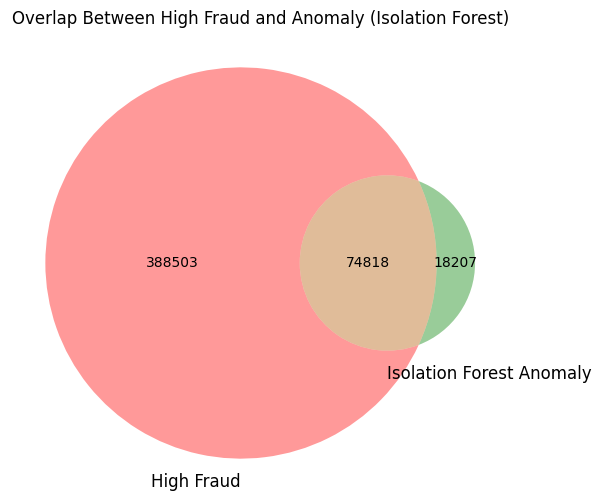

In [65]:
from matplotlib_venn import venn2

high_fraud_set = set(df_merged[df_merged['fraud_label'] == 'High Fraud']['user_session'])

# Set B: Sessions detected as Anomaly by Isolation Forest
anomaly_set = set(df_merged[df_merged['anomaly_iforest'] == 'Anomaly']['user_session'])

# Create the Venn diagram
plt.figure(figsize=(8, 6))
venn2([high_fraud_set, anomaly_set], set_labels=('High Fraud', 'Isolation Forest Anomaly'))
plt.title("Overlap Between High Fraud and Anomaly (Isolation Forest)")
plt.show()

In [67]:
# Merge anomaly_zscore from final_df into df on 'user_session'
df = df.merge(final_df[['user_session', 'anomaly_zscore']], on='user_session', how='left')

# Check if the merge was successful
print(df[['user_session', 'anomaly_zscore']].head())
print(f"Number of anomalies in df: {df['anomaly_zscore'].sum()}")


                           user_session  anomaly_zscore
0  00012d23-c857-40af-b8cb-ada787bc00cc           False
1  00016bb9-b50d-4bcb-95d1-9c375f214c66           False
2  0001d713-f9c4-4d96-8f8c-5da2bff7bbf9           False
3  000242ef-7e45-454c-a94c-6c1fd351a974           False
4  0002c5ea-3509-4d0b-9618-7e40925005f0           False
Number of anomalies in df: 518851


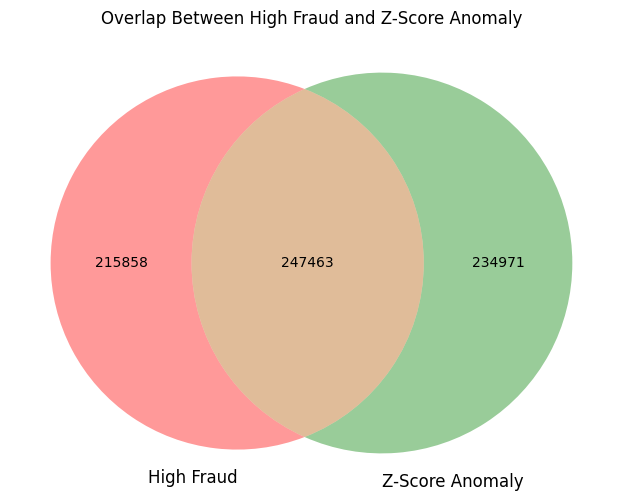

In [69]:


# Set A: High Fraud sessions
high_fraud_set = set(df[df['fraud_label'] == 'High Fraud']['user_session'])

# Set B: Z-Score Anomalies (boolean True)
zscore_anomaly_set = set(df[df['anomaly_zscore'] == True]['user_session'])

# Plot Venn diagram
plt.figure(figsize=(8, 6))
venn2([high_fraud_set, zscore_anomaly_set], set_labels=('High Fraud', 'Z-Score Anomaly'))
plt.title("Overlap Between High Fraud and Z-Score Anomaly")
plt.show()


# Fraud Detection model

In [77]:
columns_to_keep = [
    'session_duration_min_norm', 'num_views_norm', 'num_cart_norm', 
    'num_purchase_norm', 'unique_brands_norm', 'unique_categories_norm', 
    'total_spent_norm', 'fraud_score', 'is_fraud', 'fraud_label_encoded'
]


In [78]:
df_reduced = df[columns_to_keep].copy()


MemoryError: Unable to allocate 585. MiB for an array with shape (8, 9587423) and data type float64

In [75]:
from sklearn.utils import shuffle

# Shuffle the entire dataframe
df_shuffled = shuffle(df, random_state=42)

# Now do your train-test split
from sklearn.model_selection import train_test_split

X = df_shuffled[features]  # Your selected features
y = df_shuffled['fraud_label_encoded']  # Assuming binary labels (0: Normal, 1: High Fraud)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


MemoryError: Unable to allocate 512. MiB for an array with shape (7, 9587423) and data type int64

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    100585
           1       1.00      1.00      1.00   1816900

    accuracy                           1.00   1917485
   macro avg       1.00      0.99      1.00   1917485
weighted avg       1.00      1.00      1.00   1917485

Confusion Matrix:
 [[  99606     979]
 [    659 1816241]]
